In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 
import pandas as pd
from glob import glob
from astropy.io import fits
from photutils import *
from astropy.visualization import *
import insight as ih

In [2]:
#directories for the bias data
bias_directory_008 = 'data/darks/0.008'
bias_directory_009 = 'data/darks/0.009'

In [3]:
#biases for 0.008 s and 0.009 s exposures 
bias_008,std_008 = ih.bias_calc(bias_directory_008)
bias_009,std_009 = ih.bias_calc(bias_directory_009)

In [4]:
std_err_008 = std_008/np.sqrt(len(os.listdir(bias_directory_008)))
std_err_009 = std_009/np.sqrt(len(os.listdir(bias_directory_009)))

In [5]:
print('For exposure time of 0.008s the average bias is', bias_008)
print('Standard deviation', std_008)
print('Standard error',std_err_008)
print('For exposure time of 0.009s the average bias is', bias_009)
print('Standard deviation',std_009)
print('Standard error',std_err_009)

For exposure time of 0.008s the average bias is 766.3802704883889
Standard deviation 28.476783627343334
Standard error 5.199125585963244
For exposure time of 0.009s the average bias is 766.4963268640007
Standard deviation 28.424245044490817
Standard error 5.189533396974018


In [6]:
saturn_directory = 'data/saturn/luminance'

In [7]:
saturn_raw_data = ih.multiple_fits(saturn_directory)

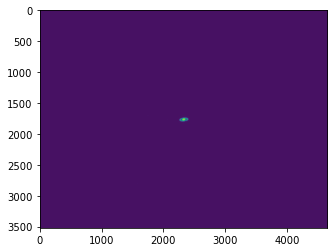

In [8]:
plt.imshow(saturn_raw_data[0])

In [9]:
saturn_raw_data = saturn_raw_data - bias_009

In [10]:
x0, y0 = centroid_quadratic(saturn_raw_data[0], fit_boxsize = 1000)
print(x0,y0)

2321.389322116435 1761.2773663238852


In [11]:
centroids_x,centroids_y = ih.calculate_centroids(saturn_raw_data)

In [12]:
xoffset =  -(centroids_x - x0)
yoffset =  -(centroids_y - y0)

In [13]:
lintrans = ih.transformation_matrices(xoffset,yoffset)
lintrans[0]

array([[ 1.        ,  0.        , -3.56666417],
       [ 0.        ,  1.        , -0.28995388]])

In [14]:
rows, cols = saturn_raw_data[0].shape[:2] 

In [15]:
new_saturn_data = ih.image_registration(saturn_raw_data,lintrans,rows,cols)

In [16]:
ref_img = np.array(saturn_raw_data[0])

In [17]:
saturn_centred_data = np.concatenate(([ref_img], new_saturn_data))

In [18]:
saturn_centred_data.shape

(13, 3520, 4656)

In [19]:
#uncomment to get the .fits files
#saturn_centred = 'data/saturn_centred'
#name = 'saturn'
#ih.write_to_fits(saturn_centred,saturn_centred_data,name)

In [34]:
#excluding Saturn itself from sources detection
mask = np.zeros(saturn_centred_data[0].shape, dtype=bool)
mask[1738:1802, 2254:2398] = True
mask[0:1700, 0:4656] = True
mask[2000:3520,0:4656] = True
mask[0:3520,2300:4564] = True
mask
norm = simple_norm(saturn_centred_data[0], 'sqrt', percent=99.9)
#excluding random noise and stars
threshold = 300

In [35]:
moons = ih.find_moons(saturn_centred_data,mask,threshold)

In [36]:
moons_df = pd.DataFrame(moons)
moons_df.head()

,x_peak,y_peak,peak_value
0,1744,1703,433.503673
1,1740,1702,1351.722423
2,2057,1761,396.691173
3,1742,1700,1290.753673
4,2059,1758,460.753673


In [37]:
moons_df.shape

(19, 3)

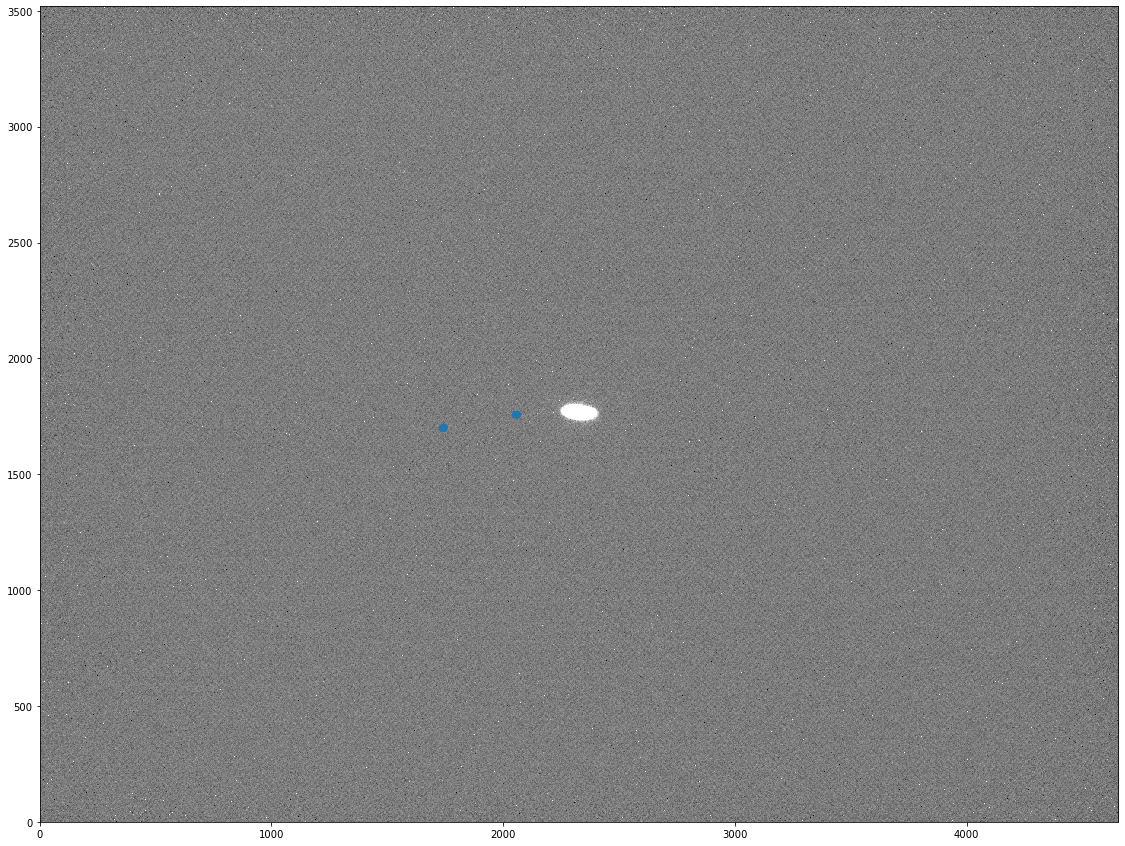

In [39]:
plt.figure(figsize = (20,15))
plt.xlim(0, saturn_centred_data[0].shape[1]-1)
plt.ylim(0, saturn_centred_data[0].shape[0]-1)
plt.scatter(moons_df['x_peak'],moons_df['y_peak'])
plt.imshow(saturn_centred_data[0], cmap='Greys_r', origin='lower', norm=norm, interpolation='nearest')

In [43]:
Moon_1 = np.array(moons_df[moons_df['x_peak'] < 2000])
Moon_2 = np.array(moons_df[moons_df['x_peak'] > 2000])

In [44]:
cols = ['x_peak','y_peak','peak_value']
Moon_1_df = pd.DataFrame(Moon_1,columns = cols)
Moon_2_df = pd.DataFrame(Moon_2,columns = cols)

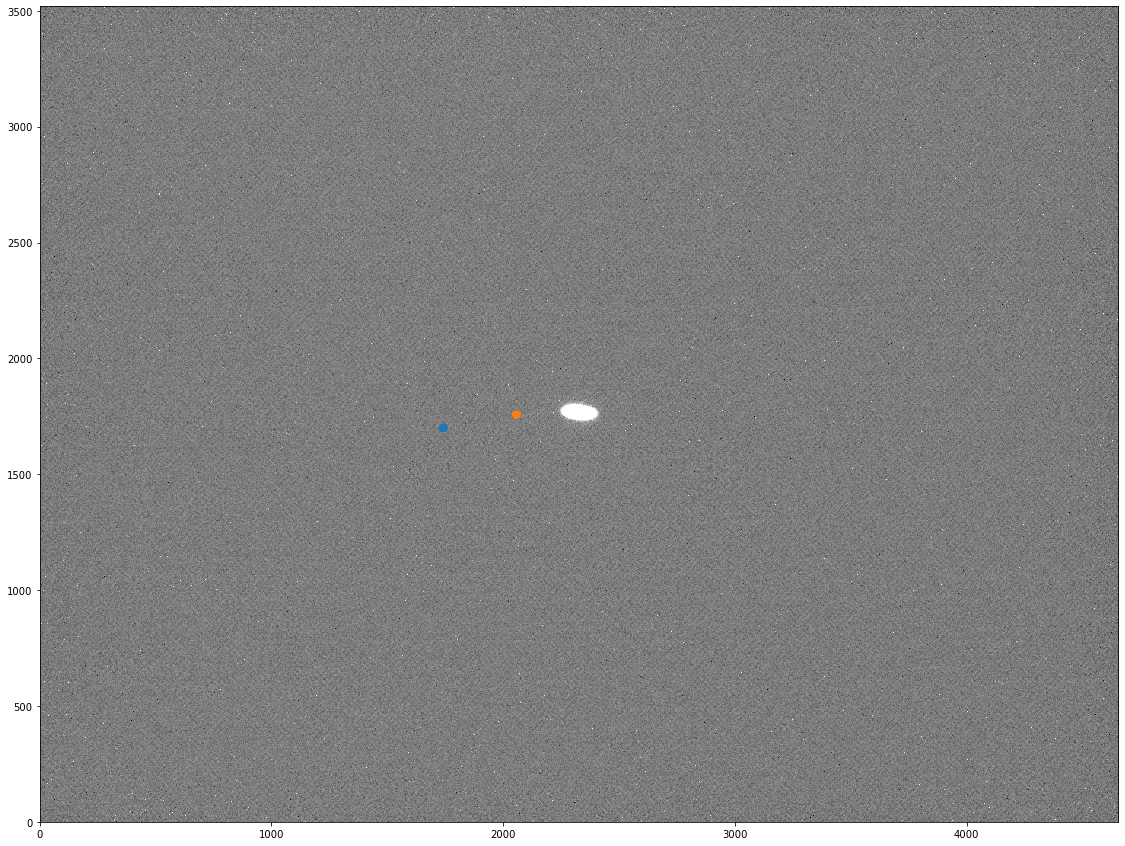

In [45]:
plt.figure(figsize = (20,15))
plt.xlim(0, saturn_centred_data[0].shape[1]-1)
plt.ylim(0, saturn_centred_data[0].shape[0]-1)
plt.scatter(Moon_1_df['x_peak'],Moon_1_df['y_peak'])
plt.scatter(Moon_2_df['x_peak'],Moon_2_df['y_peak'])
plt.imshow(saturn_centred_data[0], cmap='Greys_r', origin='lower', norm=norm, interpolation='nearest')

In [46]:
Moon_1_df.to_csv (r'data/saturn_moons/moon1.csv', index = False)
Moon_2_df.to_csv (r'data/saturn_moons/moon2.csv', index = False)